In [23]:
import geopandas as gpd
import pandas as pd
import numpy as np
import os

# Import geomap of the Netherlands
mapdf = gpd.read_file('Data/NL-geomap/gemeente_2018_v3.shp')
mapdf = mapdf[mapdf["H2O"] == "NEE"]
mapdf.sort_values("GM_NAAM", inplace=True)
mapdf = mapdf.reset_index(drop=True)
print(mapdf.columns)

# Compute distances between all municipalities
mapdf['GEO_CENTROID'] = mapdf.centroid
centres = mapdf['GEO_CENTROID']
n_mun = mapdf.shape[0]

# dist_matrix = np.zeros(shape=(n_mun, n_mun))
# for i in range(0, n_mun):
#     dist_matrix[i] = centres.distance(centres[i])

# Compute mobility based gravity model, without distances
population = mapdf['AANT_INW']
mob_matrix = np.zeros(shape=(n_mun, n_mun))
for i in range(0, n_mun):
    for j in range(0, n_mun):
        if i != j:
            mob_matrix[i,j] = population[i] * population[j]

# Import original data to normalize to
df_mobmat_freq = pd.read_csv('Data/Mob_grav_freq.csv', delimiter=',')
mobmat_freq = df_mobmat_freq[df_mobmat_freq.columns[1:]].to_numpy()

df_mobmat_inc = pd.read_csv('Data/Mob_grav_inc.csv', delimiter=',')
mobmat_inc = df_mobmat_inc[df_mobmat_inc.columns[1:]].to_numpy()

# Normalize row sums to original data, so total amount traveled per municipality is the same.
mob_matrix_freq = np.zeros(shape=(n_mun, n_mun))
mob_matrix_inc = np.zeros(shape=(n_mun, n_mun))
for i in range(n_mun):
    diff_freq = np.nansum(mob_matrix[i]) / np.nansum(mobmat_freq[i])
    mob_matrix_freq[i] = mob_matrix[i] / diff_freq

    diff_inc  = np.nansum(mob_matrix[i]) / np.nansum(mobmat_inc[i])
    mob_matrix_inc[i] = mob_matrix[i] / diff_inc

# Save the new matrix
path = os.getcwd() + '/Data/'
np.save(path + 'Randomized_mob_grav_freq', mob_matrix_freq)
np.save(path + 'Randomized_mob_grav_inc', mob_matrix_inc)

Index(['GM_CODE', 'GM_NAAM', 'H2O', 'OAD', 'STED', 'BEV_DICHTH', 'AANT_INW',
       'AANT_MAN', 'AANT_VROUW', 'P_00_14_JR',
       ...
       'AV20PODIUM', 'AF_MUSEUM', 'AV5_MUSEUM', 'AV10MUSEUM', 'AV20MUSEUM',
       'JRSTATCODE', 'JAAR', 'Shape_Leng', 'Shape_Area', 'geometry'],
      dtype='object', length=205)


In [59]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib
import pandas as pd
import numpy as np
import os

ppl_per_agent = 100

path_gem_names = os.getcwd() + '/Data/Gem_alfabetisch_2018.csv'

DF_Gem = pd.read_csv(path_gem_names, delimiter=';', encoding='latin-1')
UniLocs = np.unique(DF_Gem.Gemeentenaam)
UniIDs = [list(DF_Gem.GemeentecodeGM[DF_Gem.Gemeentenaam == i])[0] for i in UniLocs]

path_demo = os.getcwd() + '/Data/DemographicMatrix.csv'

DF_Demo = pd.read_csv(path_demo, delimiter=',')
DemoIDs = np.array(DF_Demo['Unnamed: 0'])
DemoMat_unsorted = np.array(DF_Demo[DF_Demo.keys()[1:]])
DemoMat_sorted = []
for ID in UniIDs:
    DemoMat_sorted.append(DemoMat_unsorted[DemoIDs == int(ID.lstrip('GM'))])
DemoMat = (np.array(DemoMat_sorted)/ppl_per_agent).astype(int)[:, 0]

DemoFractionsMat = np.zeros(shape=DemoMat.shape)
for i in range(0, DemoMat.shape[0]):
    DemoFractionsMat[i] = DemoMat[i] / np.sum(DemoMat[i])



# Useful functions
def create_spatial_plot(data_per_municipality, title, legend_label):
    '''
    Plot map with data per municipality
    '''
    mapdf = gpd.read_file('Data/NL-geomap/gemeente_2018_v3.shp')
    mapdf = mapdf[mapdf["H2O"] == "NEE"]
    mapdf.sort_values("GM_NAAM", inplace=True)
    mapdf = mapdf.reset_index(drop=True)

    max_val = np.max(data_per_municipality)

    fig, ax = plt.subplots(1, 1, figsize=(8,8))
    fig.suptitle(title)
    ax.axis('off')

    mapdf.insert(0, 'DATA', data_per_municipality)

    mapdf.plot(ax=ax, column="DATA", 
               legend=True, legend_kwds={"label": legend_label, "orientation": "vertical"})

    plt.plot()

def create_spatial_plot_log(data_per_municipality, title, legend_label):
    '''
    Plot map with data per municipality
    '''
    mapdf = gpd.read_file('Data/NL-geomap/gemeente_2018_v3.shp')
    mapdf = mapdf[mapdf["H2O"] == "NEE"]
    mapdf.sort_values("GM_NAAM", inplace=True)
    mapdf = mapdf.reset_index(drop=True)

    max_val = np.max(data_per_municipality)

    fig, ax = plt.subplots(1, 1, figsize=(8,8))
    fig.suptitle(title)
    ax.axis('off')

    mapdf.insert(0, 'DATA', data_per_municipality)

    mapdf.plot(ax=ax, column="DATA", 
               legend=True, legend_kwds={"label": legend_label, "orientation": "vertical"}, norm=matplotlib.colors.LogNorm(1, max_val))

    plt.plot()



def create_spatial_4plots(data_per_municipality, title, legend_label):
    '''
    Plot 4 maps, evenly spread out over time
    '''
    mapdf = gpd.read_file('Data/NL-geomap/gemeente_2018_v3.shp')
    mapdf = mapdf[mapdf["H2O"] == "NEE"]
    mapdf.sort_values("GM_NAAM", inplace=True)
    mapdf = mapdf.reset_index(drop=True)

    max_time = data_per_municipality.shape[0]
    max_val = np.max(data_per_municipality[max_time-1])

    fig, axs = plt.subplots(1, 4, figsize=(20, 8))
    fig.suptitle(title)

    mapdf.insert(0, 'DATA_QUARTER', data_per_municipality[int(max_time/4)])
    mapdf.insert(0, 'DATA_HALF', data_per_municipality[int(max_time/2)])
    mapdf.insert(0, 'DATA_3QUARTER', data_per_municipality[int(max_time*3/4)])
    mapdf.insert(0, 'DATA_MAXTIME', data_per_municipality[max_time-1])

    mapdf.plot(ax=axs[0], column="DATA_QUARTER", norm=matplotlib.colors.LogNorm(1,max_val))
    mapdf.plot(ax=axs[1], column="DATA_HALF", norm=matplotlib.colors.LogNorm(1,max_val))
    mapdf.plot(ax=axs[2], column="DATA_3QUARTER", norm=matplotlib.colors.LogNorm(1,max_val))
    mapdf.plot(ax=axs[3], column="DATA_MAXTIME", norm=matplotlib.colors.LogNorm(1,max_val))


    axs[0].set_title('t=' + str(int(max_time/4)))
    axs[1].set_title('t=' + str(int(max_time/2)))
    axs[2].set_title('t=' + str(int(max_time*3/4)))
    axs[3].set_title('t=' + str(int(max_time-1)))

    axs[0].axis('off')
    axs[1].axis('off')
    axs[2].axis('off')
    axs[3].axis('off')

    mappable = cm.ScalarMappable(
        norm=mcolors.Normalize(1, max_val))

    cb_ax = fig.add_axes([0.1, 0.1, 0.8, 0.02])

    cbar = fig.colorbar(mappable, cax=cb_ax, orientation='horizontal')
    cbar.set_label(legend_label)

    plt.tight_layout()
    plt.plot()


# DAILY PLOT FOR 1 WEEK

def create_spatial_7plots(data_per_municipality, max_legend_val, title, legend_label, print_foi_sums=False):
    '''
    Plot a daily map for 1 week
    '''
    mapdf = gpd.read_file('Data/NL-geomap/gemeente_2018_v3.shp')
    mapdf = mapdf[mapdf["H2O"] == "NEE"]
    mapdf.sort_values("GM_NAAM", inplace=True)
    mapdf = mapdf.reset_index(drop=True)

    max_time = data_per_municipality.shape[0]
    if max_legend_val == None:
        max_legend_val = np.max(data_per_municipality[max_time-1])

    fig, axs = plt.subplots(1, 7, figsize=(21, 5))
    fig.suptitle(title)

    for day in range(0, 7):
        day_num = day + 1
        mapdf.insert(0, 'DAY_' + str(day_num), data_per_municipality[day_num * 24 - 1])
        if print_foi_sums:
            print('Day ' + str(day_num) + ': ' + str(np.sum(data_per_municipality[day_num * 24 - 1])))
        mapdf.plot(ax=axs[day], column='DAY_' + str(day_num), norm=matplotlib.colors.LogNorm(1, max_legend_val))
        axs[day].set_title('Day ' + str(day_num))
        axs[day].axis('off')

    mappable = cm.ScalarMappable(
        norm=matplotlib.colors.LogNorm(1, max_legend_val))

    cb_ax = fig.add_axes([0.1, 0.1, 0.8, 0.02])

    cbar = fig.colorbar(mappable, cax=cb_ax, orientation='horizontal')
    cbar.set_label(legend_label)

    plt.tight_layout()
    plt.plot()


def create_spatial_7plots3(data_per_municipality, max_legend_val, title, legend_label, print_foi_sums=False):
    '''
    Plot 7 maps, spaced 3 days apart
    '''
    mapdf = gpd.read_file('Data/NL-geomap/gemeente_2018_v3.shp')
    mapdf = mapdf[mapdf["H2O"] == "NEE"]
    mapdf.sort_values("GM_NAAM", inplace=True)
    mapdf = mapdf.reset_index(drop=True)

    max_time = data_per_municipality.shape[0]
    if max_legend_val == None:
        max_legend_val = np.max(data_per_municipality[max_time-1])

    fig, axs = plt.subplots(1, 7, figsize=(21, 5))
    fig.suptitle(title)

    for day in range(0, 7):
        day_num = (day + 1) * 3
        mapdf.insert(0, 'DAY_' + str(day_num), data_per_municipality[day_num * 24 - 1])
        if print_foi_sums:
            print('Day ' + str(day_num) + ': ' + str(np.sum(data_per_municipality[day_num * 24 - 1])))
        mapdf.plot(ax=axs[day], column='DAY_' + str(day_num), norm=matplotlib.colors.LogNorm(1, max_legend_val))
        axs[day].set_title('Day ' + str(day_num))
        axs[day].axis('off')

    mappable = cm.ScalarMappable(
        norm=matplotlib.colors.LogNorm(1, max_legend_val))

    cb_ax = fig.add_axes([0.1, 0.1, 0.8, 0.02])

    cbar = fig.colorbar(mappable, cax=cb_ax, orientation='horizontal')
    cbar.set_label(legend_label)

    plt.tight_layout()
    plt.plot()

def create_spatial_7plots3_linear(data_per_municipality, max_legend_val, title, legend_label, print_foi_sums=False):
    '''
    Plot 7 maps, spaced 3 days apart
    '''
    mapdf = gpd.read_file('Data/NL-geomap/gemeente_2018_v3.shp')
    mapdf = mapdf[mapdf["H2O"] == "NEE"]
    mapdf.sort_values("GM_NAAM", inplace=True)
    mapdf = mapdf.reset_index(drop=True)

    max_time = data_per_municipality.shape[0]
    if max_legend_val == None:
        max_legend_val = np.max(data_per_municipality[max_time-1])
    min_legend_val = np.min(data_per_municipality[max_time-1])

    print(max_legend_val)
    print(min_legend_val)

    fig, axs = plt.subplots(1, 7, figsize=(21, 5))
    fig.suptitle(title)

    for day in range(0, 7):
        day_num = (day + 1) * 3
        mapdf.insert(0, 'DAY_' + str(day_num), data_per_municipality[day_num * 24 - 1])
        if print_foi_sums:
            print('Day ' + str(day_num) + ': ' + str(np.sum(data_per_municipality[day_num * 24 - 1])))
        mapdf.plot(ax=axs[day], column='DAY_' + str(day_num), legend=True)
        axs[day].set_title('Day ' + str(day_num))
        axs[day].axis('off')

    plt.tight_layout()
    plt.plot()


def combine_runs_avg(all_run_data, padding=0.000001):
    merged_data = np.zeros(shape= all_run_data[0].shape)
    for i in range (0, len(all_run_data)):
        merged_data = merged_data + all_run_data[i]
    merged_data = (merged_data / len(all_run_data)) + padding
    return merged_data

def combine_demos_weighted(municipality_id, demo_run_data, padding=0.000001):
    fracs = DemoFractionsMat[municipality_id]
    merged_data = np.zeros(shape= demo_run_data[0].shape)
    for i in range (0, len(demo_run_data)):
        weighted = fracs[i] * demo_run_data[i]
        merged_data = merged_data + weighted
    merged_data = merged_data + padding
    return merged_data


In [39]:
import pandas as pd
import numpy as np
import os

def load_total_infected_per_municipality(path_data, loc, group, run):
    # Load general model data
    peopleDF = pd.read_pickle(path_data + 'PeopleDF.pkl')
    extraPeopleDF = pd.read_pickle(path_data + 'ExtraPeopleDF.pkl')
    status = np.load(path_data + 'Runs_ref_4.6_100_5_risk' + str(loc) + '_' + str(group) + '/Status_' + str(run) + '.npz')
    uniLocs = np.array(pd.read_pickle(os.path.normpath(path_data + '../../Gemeenten.pkl'))).T[0]
    loc_to_id = {val: i for i, val in enumerate(uniLocs)}
    uniGroups = np.unique(np.array(extraPeopleDF.Group))

    extra_agents = extraPeopleDF.loc[(extraPeopleDF['Home'] == uniLocs[loc]) & (extraPeopleDF['Group'] == uniGroups[group])]
    peopleDF = pd.concat([peopleDF, extra_agents], ignore_index=True)

    # Load model output data
    timesteps = status['indptr'].shape[0] - 1
    data = status['data']
    indptr = status['indptr']
    indices = status['indices']

    # Compute for every timestep how many infected people there are in every municipality
    infected_per_municipality = np.zeros((timesteps, 380))
    for t in range(0, timesteps):
        data_t = data[indptr[t] : indptr[t + 1]]
        agents_status_t = indices[indptr[t] : indptr[t + 1]]

        infected_agents = agents_status_t[(data_t == 2) | (data_t == 3)]
        infected_agents_homes = np.array(peopleDF.loc[infected_agents]['Home'])
        for home in infected_agents_homes:
            infected_per_municipality[t, loc_to_id[home]] += 1

    return infected_per_municipality

def load_total_infected_avg_runs(path_data, loc, group, seeds, runs_per_seed):
    all_data = []
    for seed in range(seeds):
        path = path_data + f'Seed_{seed}/'
        for run in range(runs_per_seed):
            all_data.append(load_total_infected_per_municipality(path, loc, group, run))
            # print("Loaded & computed loc: " +str(loc) + " group: " + str(group) + " run: " + str(run)) 

    # Average the data
    n_data = seeds * runs_per_seed
    merged_data = np.zeros(all_data[0].shape)
    for i in range(n_data):
        merged_data = merged_data + all_data[i]
    merged_data = merged_data / n_data
    return merged_data

0	's-Gravenhage:  99.95
1	's-Hertogenbosch:  111.10000000000001
2	Aa en Hunze:  80.95
3	Aalburg:  118.39999999999999
4	Aalsmeer:  132.79999999999998
5	Aalten:  89.0
6	Achtkarspelen:  74.85
7	Alblasserdam:  124.6
8	Albrandswaard:  143.35000000000002
9	Alkmaar:  111.9
10	Almelo:  99.45
11	Almere:  109.9
12	Alphen aan den Rijn:  105.29999999999998
13	Alphen-Chaam:  105.25000000000001
14	Ameland:  68.75
15	Amersfoort:  146.90000000000003
16	Amstelveen:  115.65
17	Amsterdam:  117.65000000000002
18	Apeldoorn:  91.0
19	Appingedam:  75.9
20	Arnhem:  116.7
21	Assen:  69.85
22	Asten:  97.25
23	Baarle-Nassau:  112.2
24	Baarn:  106.44999999999999
25	Barendrecht:  159.75
26	Barneveld:  101.39999999999999
27	Bedum:  116.29999999999998
28	Beek:  82.7
29	Beemster:  121.44999999999999
30	Beesel:  99.94999999999999
31	Berg en Dal:  114.79999999999998
32	Bergeijk:  118.89999999999999
33	Bergen (L.):  81.5
34	Bergen (NH.):  108.9
35	Bergen op Zoom:  101.4
36	Berkelland:  71.85
37	Bernheze:  113.65
38	Best

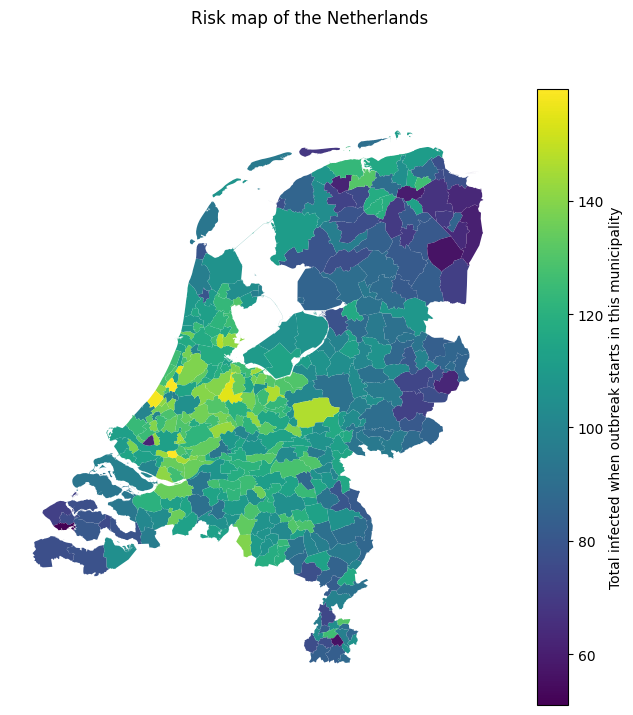

In [11]:
path = os.getcwd() + '/cluster/results/3/High/'

loc_name = np.array(pd.read_pickle(path + 'Gemeenten.pkl')).T[0]
n_mun = len(loc_name)
t_max = 21 * 24

risk_map = np.zeros(n_mun)
infected_per_municipality = np.zeros((n_mun, t_max, n_mun))
for loc in range(n_mun):
    infected_per_municipality[loc] = load_total_infected_avg_runs(path, loc, 3, 20, 1)
    risk_map[loc] = np.sum(infected_per_municipality[loc, t_max - 1])
    print(str(loc) +'\t' + loc_name[loc] + ':  ' + str(risk_map[loc]))

# Store the infected data per municipality, because it takes a while to generate
np.save(path + 'Infected_Per_Municipality_New', infected_per_municipality)

create_spatial_plot(risk_map, 'Risk map of the Netherlands', 'Total infected when outbreak starts in this municipality')



0	's-Gravenhage:  3596.9538633125117
1	's-Hertogenbosch:  4181.60131148312
2	Aa en Hunze:  3000.461583728872
3	Aalburg:  4455.616458584733
4	Aalsmeer:  4919.728049011937
5	Aalten:  3165.6480973024377
6	Achtkarspelen:  2687.1167980858418
7	Alblasserdam:  4704.515490368575
8	Albrandswaard:  5546.715837491636
9	Alkmaar:  4153.159142869123
10	Almelo:  3711.3657614460085
11	Almere:  4084.3939209785817
12	Alphen aan den Rijn:  3894.5686870691993
13	Alphen-Chaam:  3859.3923996125054
14	Ameland:  2379.285982223448
15	Amersfoort:  5453.651085866789
16	Amstelveen:  4211.959257090903
17	Amsterdam:  4325.7160333743495
18	Apeldoorn:  3364.2844721795236
19	Appingedam:  2637.975733903495
20	Arnhem:  4431.765002515027
21	Assen:  2471.020959595558
22	Asten:  3488.349780937732
23	Baarle-Nassau:  4013.178235465914
24	Baarn:  3927.6317770157343
25	Barendrecht:  6020.0800834659185
26	Barneveld:  3804.1038205213104
27	Bedum:  4241.031811341961
28	Beek:  2994.7317680624565
29	Beemster:  4718.58237396614
30	B

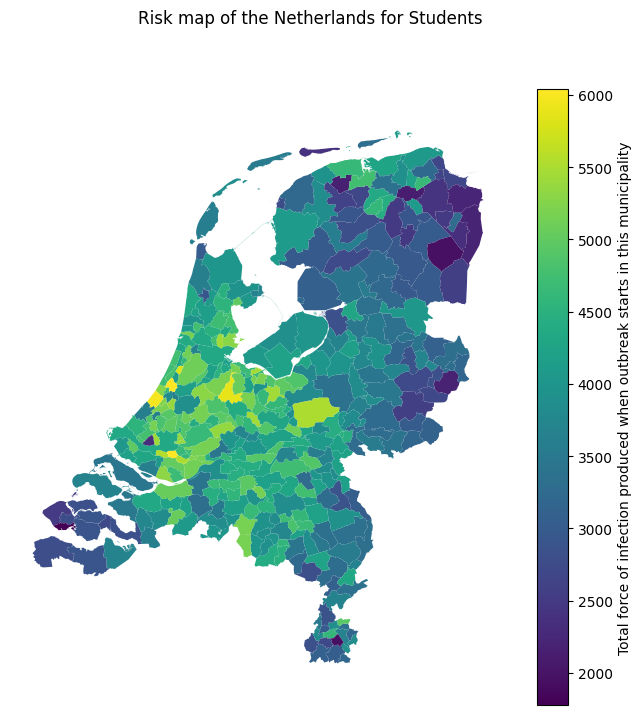

In [5]:
def load_foi_avg_runs(path_data, loc, group, seeds, runs):
    all_data = []
    for seed in range(seeds):
        path = path_data + f'Seed_{seed}/'
        for run in range(runs):
            foi_data = np.load(path + 'Runs_ref_4.6_100_5_risk' + str(loc) + '_' + str(group) + '/Infection_Pressure_' + str(run) + '.npy')
            all_data.append(foi_data)

    # Average the data
    n_data = seeds * runs
    merged_data = np.zeros(all_data[0].shape)
    for i in range(n_data):
        merged_data = merged_data + all_data[i]
    merged_data = merged_data / n_data
    return merged_data

path = os.getcwd() + '/cluster/results/3/High/'

loc_name = np.array(pd.read_pickle(path + 'Gemeenten.pkl')).T[0]

risk_map = np.zeros(380)
for loc in range(380):
    infected_per_municipality = load_foi_avg_runs(path, loc, 3, 20, 1)
    t_max = infected_per_municipality.shape[0]
    risk = np.sum(infected_per_municipality[t_max - 1])
    risk_map[loc] = risk
    print(str(loc) +'\t' + loc_name[loc] + ':  ' + str(risk))

create_spatial_plot(risk_map, 'Risk map of the Netherlands for Students', 'Total force of infection produced when outbreak starts in this municipality')

25	Barendrecht: 159.75
304	Teylingen: 159.25
341	Wassenaar: 158.25
151	Hillegom: 155.20000000000002
297	Stichtse Vecht: 155.05
176	Landsmeer: 148.60000000000002
15	Amersfoort: 146.90000000000003
93	Ede: 146.65
378	Zwijndrecht: 145.5
60	Capelle aan den IJssel: 145.3
160	Huizen: 143.75
8	Albrandswaard: 143.35000000000002
194	Lopik: 142.9
57	Bunnik: 142.35
333	Voorschoten: 141.9
277	Schiedam: 141.9
342	Waterland: 141.60000000000002
64	Cromstrijen: 141.25
171	Krimpen aan den IJssel: 141.00000000000003
166	Katwijk: 140.4
372	Zoeterwoude: 140.1
220	Nieuwkoop: 139.9
74	Delft: 139.6
72	De Ronde Venen: 139.5
253	Papendrecht: 139.39999999999998
265	Rhenen: 139.35
263	Reusel-De Mierden: 138.95
128	Haarlemmermeer: 138.65
53	Brielle: 138.35000000000002
344	Weesp: 138.04999999999998
214	Montfoort: 137.5
185	Leidschendam-Voorburg: 137.45
69	De Bilt: 137.35
126	Haarlem: 136.95
94	Eemnes: 136.9
45	Bodegraven-Reeuwijk: 136.7
179	Laren: 136.6
335	Vught: 135.95
40	Beverwijk: 135.7
274	Rucphen: 135.25
85	D

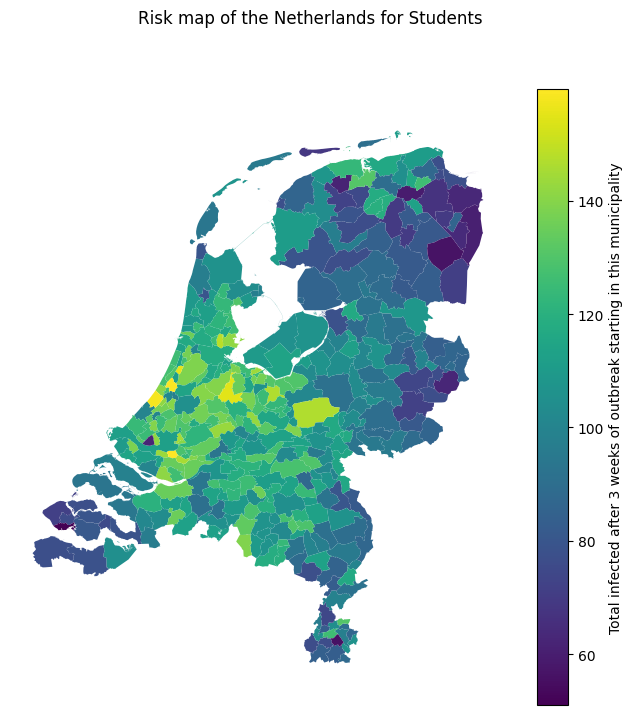

In [20]:
infected_per_municipality = np.load(os.getcwd() + '/cluster/results/3/High/Infected_Per_Municipality_New.npy')
#infected_per_municipality = risk_map
n_municipalities = infected_per_municipality.shape[0]
risk_data = np.zeros(n_municipalities)
for i in range(n_municipalities):
    risk_data[i] = np.sum(infected_per_municipality[i, t_max-1])

for loc in np.argsort(risk_data)[::-1]:
    print(str(loc) + '\t' + loc_name[loc] + ': ' + str(risk_data[loc]))


create_spatial_plot(risk_data, 'Risk map of the Netherlands for Students', 'Total infected after 3 weeks of outbreak starting in this municipality')

In [1]:
import os

path = os.getcwd() + '/cluster/results/3/High/Seed_13/'

missing_dirs = []
for run in range(380):
    if not os.path.isdir(path + f'Runs_ref_4.6_100_5_risk{run}_3'):
        print(f'Run: {run} | Job: {int(run/16)}')


329	Vlaardingen: 32.78305782788043
268	Rijswijk: 20.96193031496891
185	Leidschendam-Voorburg: 13.231152845609898
366	Zandvoort: 13.065497240319088
341	Wassenaar: 12.649128837669977
23	Baarle-Nassau: 12.535388185296252
372	Zoeterwoude: 12.459888974741418
137	Heemstede: 12.390171214501622
277	Schiedam: 12.354547232488448
344	Weesp: 12.057473859892122
262	Renswoude: 11.8573325633485
333	Voorschoten: 11.778245221425086
179	Laren: 11.646083472368769
355	Wijdemeren: 11.228929760031022
24	Baarn: 11.205244405951468
43	Blaricum: 11.18761066208164
7	Alblasserdam: 11.152351378120063
285	Sliedrecht: 11.086078752014863
151	Hillegom: 11.085691290242291
342	Waterland: 11.083778613163469
266	Ridderkerk: 11.056262434597333
107	Geertruidenberg: 11.046086054500464
250	Ouder-Amstel: 11.00492090496826
207	Midden-Delfland: 10.923945408354301
219	Nieuwegein: 10.8654106965631
176	Landsmeer: 10.858814026012753
244	Oostzaan: 10.77590011035714
71	De Marne: 10.551663807054112
171	Krimpen aan den IJssel: 10.480003

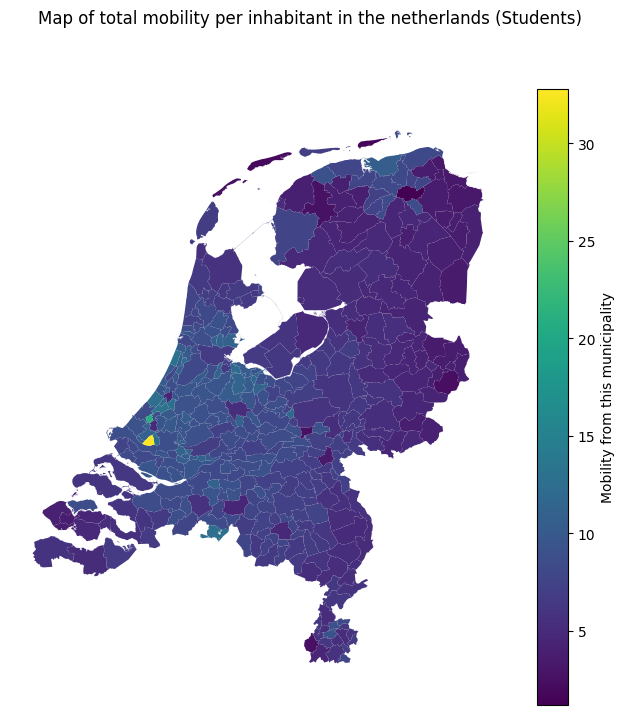

In [61]:
df_mobmat_freq = pd.read_csv('Data/Mob_grav_freq.csv', delimiter=',')
mobmat_freq = df_mobmat_freq[df_mobmat_freq.columns[1:]].to_numpy()

mobility_map = np.zeros(380)
for loc in range(380):
    demo_pop = np.maximum(DemoMat[loc, 3], 1)
    mobility_map[loc] = np.nansum(mobmat_freq[loc]) / demo_pop

for loc in np.argsort(mobility_map)[::-1]:
    print(str(loc) + '\t' + loc_name[loc] + ': ' + str(mobility_map[loc]))

create_spatial_plot(mobility_map, 'Map of total mobility per inhabitant in the netherlands (Students)', 'Mobility from this municipality')